In [313]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Accelerometer data is collected from a smartphone at frequency of 50hz(1 sec ~ 50 samples)
COLUMNS = ['timestamp','x-axis','y-axis','z-axis']
# 1 minute of walking at 50hz = 3000 accelerometer samples
walking_df = pd.read_csv("data/rishabh_23_male_walking_V3.csv",names=COLUMNS)
walking_df.shape

(3002, 4)

In [4]:
walking_df2 = pd.read_csv("data/rishabh_23_male_walking_V2.csv", names=COLUMNS)[:2000] 
standing_df = pd.read_csv("data/rishabh_23_male_standing_V2.csv", names=COLUMNS)
sitting_df = pd.read_csv("data/rishabh_23_male_sitting_V1.csv", names=COLUMNS)
standing_df.head()

,timestamp,x-axis,y-axis,z-axis
0,1565612756027,-0.970,9.435,1.216
1,1565612756027,-0.941,9.465,1.176
2,1565612756039,-0.909,9.490,0.948
3,1565612756067,-0.884,9.480,0.965
4,1565612756087,-0.860,9.456,1.067


In [5]:
def plot(activity_df,title):
    plt.figure(figsize=(18,10))
    plt.subplot(311)
    plt.title(title +" z-axis")
    plt.plot(np.arange(activity_df.shape[0]),activity_df['z-axis'])
    plt.subplot(312)
    plt.title(title +" x-axis")
    plt.plot(np.arange(activity_df.shape[0]),activity_df['x-axis'])
    plt.subplot(313)
    plt.title(title +" x-axis")
    plt.plot(np.arange(activity_df.shape[0]),activity_df['y-axis'])
    plt.show()

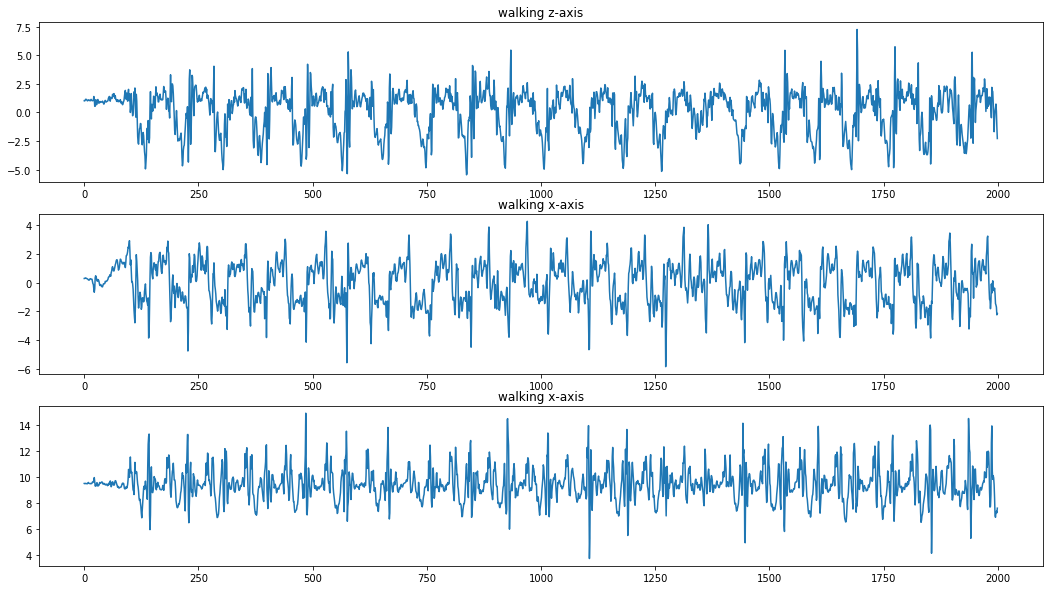

In [6]:
# Plotting x,y and z axis for all the activites
plot(walking_df2,"walking")
# Clear pattern in walking as expected

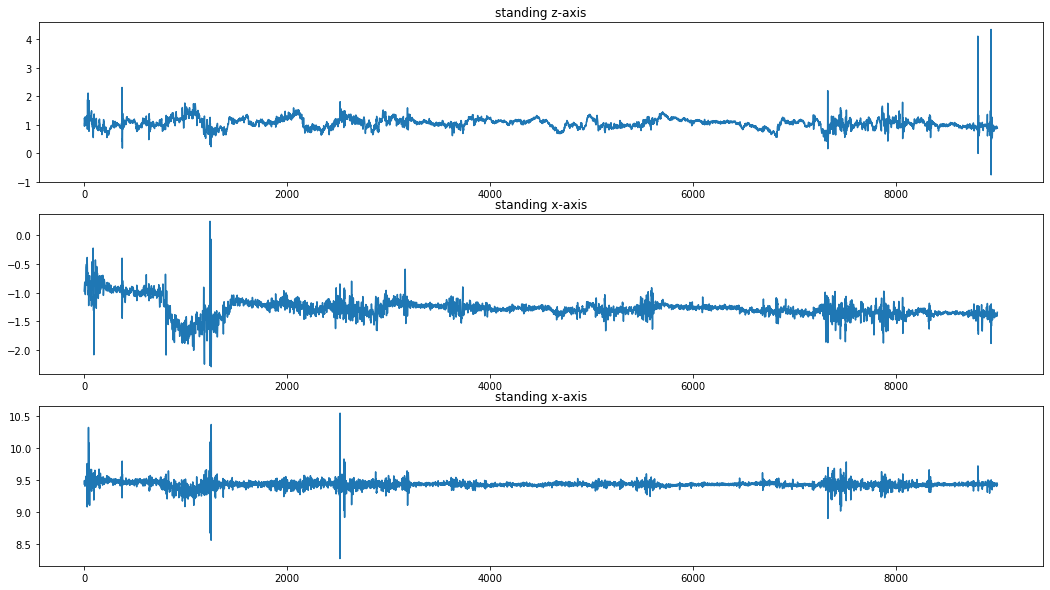

In [7]:
plot(standing_df,"standing")

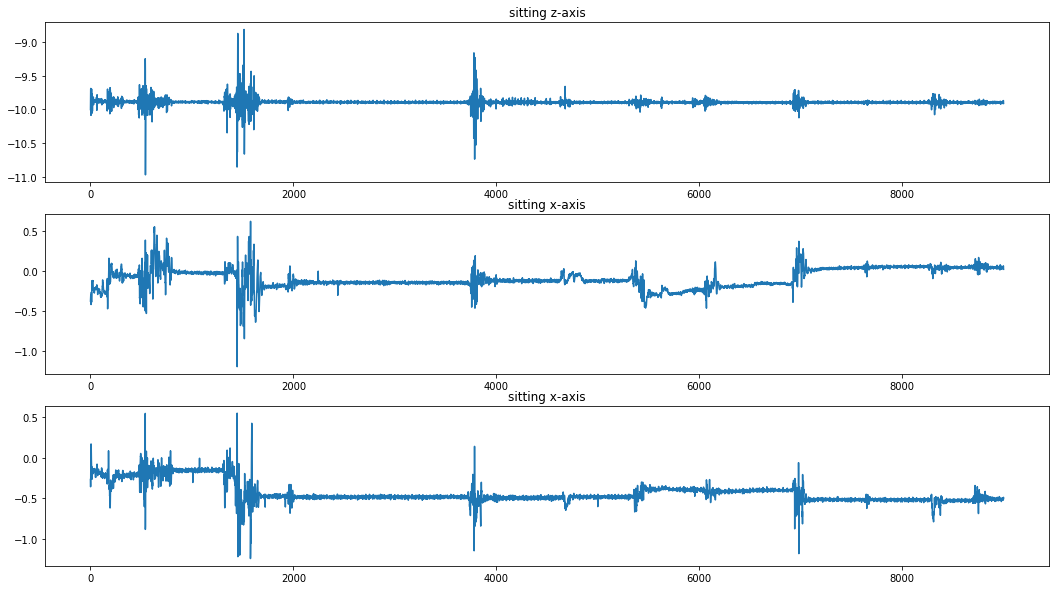

In [8]:
plot(sitting_df,"sitting")

In [9]:
# With x,y and z-axis value we are also going to extract freatures from magnitude acceleration
#magnitude acceleration = sqrt(x^2 + y^2 + z^3)

def calc_magnitude(activity_df):
    x2 = activity_df["x-axis"].pow(2)
    y2 = activity_df["y-axis"].pow(2)
    z2 = activity_df["z-axis"].pow(2)
    m = x2+y2+z2
    return m.pow(0.5)

In [10]:
def rms(activity_axis):
    return np.sqrt((activity_axis * activity_axis).sum() / activity_axis.count())

In [252]:
def extract_features_from_window(activity_axis,start,end):
    acf = stattools.acf(activity_axis[start:end])
    acv = stattools.acovf(activity_axis[start:end])
 
    return [
        activity_axis[start:end].mean(),
        activity_axis[start:end].min(),
        activity_axis[start:end].max(),
        activity_axis[start:end].std(),
        activity_axis[start:end].var(),
        rms(activity_axis[start:end]),
    ]

In [253]:
def extract_features(activity_df):
    '''
    Non-overlapping sliding window technique is used for feature extraction
    size of window is of 1 sec which is almost 50 samples
    '''

    features = []
    row_count = activity_df["x-axis"].count()
    #for every 50 samples of data,for every axis, extract features and add it to the features list
    for i in range(0,row_count,50):
        feature = []
        start = i
        end = i + 50
        if end < row_count:
            for axis in ['x-axis','y-axis','z-axis','magnitude']:
                feature.extend(extract_features_from_window(activity_df[axis],start,end))
            features.append(feature)
    return features

In [254]:
def write_features_to_file(features,label):
    with open('data/features.csv', 'a') as csvfile:
        for feature in features:
            writer = csv.writer(csvfile)
            writer.writerow(feature + [label])

In [278]:
LABELS = {"walking":0,
         "standing":1,
         "sitting":2,
         "jogging":3,
         "walkingup":4,
         "walkingdown":5}
# walking up = Walking up stairs
# walking down = Walking down stairs
# jogging ~ running

In [279]:
from os import listdir

activity_files = listdir("data")
f = open("data/features.csv","w")
f.truncate()
f.close()
for activity_name,label in LABELS.items():
    for file in activity_files:
        if activity_name in file.split("_"):
            print(file)
            activity_df = pd.read_csv("data/"+file, names = COLUMNS)
            activity_df["magnitude"] = calc_magnitude(activity_df)
            features = extract_features(activity_df)
            write_features_to_file(features,label)

rishabh_23_male_walking_V4.csv
rishabh_23_male_walking_V1.csv
rishabh_23_male_walking_V3.csv
rishabh_23_male_walking_V2.csv
rishabh_23_male_standing_V2.csv
rishabh_23_male_sitting_V1.csv
rishabh_23_male_jogging_V3.csv
rishabh_23_male_jogging_V4.csv
rishabh_23_male_jogging_V1.csv
rishabh_23_male_jogging_V2.csv
rishabh_23_male_walkingup_V2.csv
rishabh_23_male_walkingup_V1.csv
rishabh_23_male_walkingup_V3.csv
rishabh_23_male_walkingup_V4.csv
rishabh_23_male_walkingdown_V1.csv
rishabh_23_male_walkingdown_V3.csv
rishabh_23_male_walkingdown_V2.csv
rishabh_23_male_walkingdown_V4.csv


In [280]:
feat = pd.read_csv('data/features.csv')
feat.shape

(1196, 25)

In [281]:
from sklearn.model_selection import cross_val_score

def get_cross_val_score(model,features,target):
    return cross_val_score(model,features,target,cv=10).mean()

In [290]:
from sklearn.linear_model import LogisticRegression


x = feat.iloc[:,:-1]
y = feat.iloc[:,-1]

lgr = LogisticRegression()
lgr.fit(x,y)
train_error(lgr,x,y)
get_cross_val_score(lgr,x,y)

train error:  0.946236559139785


0.9373243365142667

In [283]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x,y)
get_cross_val_score(rf,x,y)

0.9331152969662442

In [284]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(x,y)
get_cross_val_score(svm,x,y)

0.9364699947775721

In [285]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x,y)
get_cross_val_score(knn,x,y)

0.9330659212837679

In [286]:
from sklearn.model_selection import train_test_split

def train_error(model,features,target):
    x_train,x_test,y_train,y_test = train_test_split(features,target,test_size = 0.3)
    model.fit(x_train,y_train)
    print("train error: ", model.score(x_train,y_train))
    return model.score(features,target)

In [294]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier((100,),activation='relu')
train_error(nn,x,y)
print("cross validation score: ",get_cross_val_score(nn,x,y))
# This neural network perfoems better

train error:  0.9629629629629629
cross validation score:  0.9448454636091725


In [308]:
from sklearn import metrics
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)
nn.fit(x_train,y_train)
pred = nn.predict(x_test)
cm = metrics.confusion_matrix(y_test,pred)

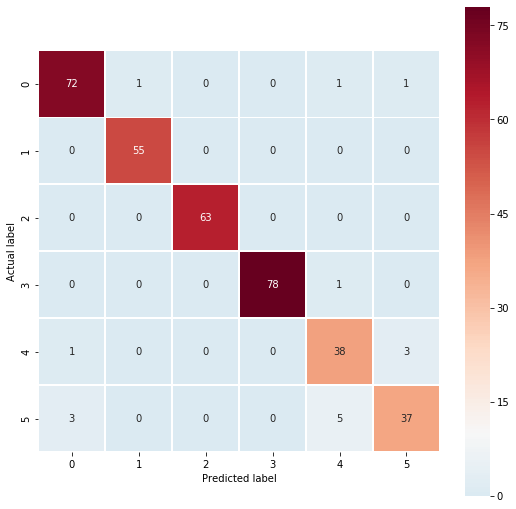

In [328]:
# there is confussion between walking,upstairs and downstairs as expected
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'RdBu_r', center = 10);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [329]:
from joblib import dump, load
dump(nn, 'models/nn_100_relu.joblib') 

['models/nn_100_relu.joblib']